## la pr√©paration des donn√©es et le feature engineering : 

### https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features

### 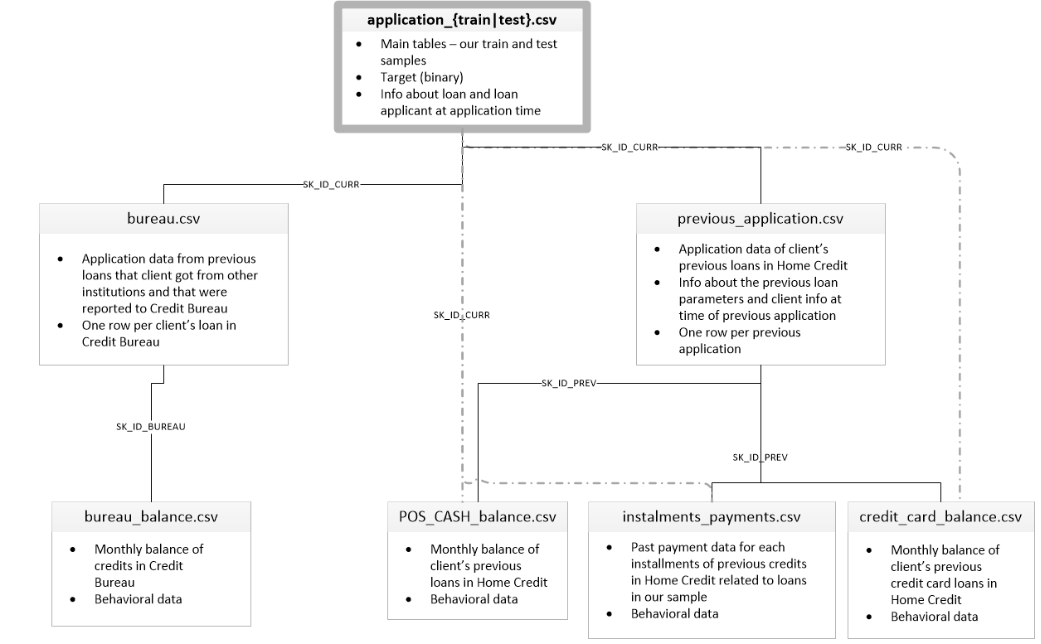

### Je souhaite que vous puissiez mettre en oeuvre au minimum les √©tapes orient√©es MLOps suivantes : 

Dans le notebook d‚Äôentra√Ænement des mod√®les, g√©n√©rer √† l‚Äôaide de MLFlow un tracking d'exp√©rimentations. 
Lancer l‚Äôinterface web 'UI MLFlow" d'affichage des r√©sultats du tracking. 
R√©aliser avec MLFlow un stockage centralis√© des mod√®les dans un ‚Äúmodel registry‚Äù. 
Tester le serving MLFlow. 
G√©rer le code avec le logiciel de version Git. 
Partager le code sur Github pour assurer une int√©gration continue. 
Utiliser Github Actions pour le d√©ploiement continu et automatis√© du code de l‚ÄôAPI sur le cloud. 
Concevoir des tests unitaires avec Pytest (ou Unittest) et les ex√©cuter de mani√®re automatis√©e lors du build r√©alis√© par Github Actions

## Feature engineering

#### Option 1 
https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [84]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
# from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
# from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    train_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\application_train.csv"
    test_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\application_test.csv"
    df = pd.read_csv(train_path, nrows=num_rows)
    test_df = pd.read_csv(test_path, nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # df = df.append(test_df).reset_index()
    df = pd.concat([df, test_df]).reset_index(drop=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\bureau.csv"
    bureau = pd.read_csv(bureau_path, nrows=num_rows)
    bb_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\bureau_balance.csv"
    bb = pd.read_csv(bb_path, nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\previous_application.csv"
    prev = pd.read_csv(prev_path, nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\POS_CASH_balance.csv"
    pos = pd.read_csv(pos_path, nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\installments_payments.csv"
    ins = pd.read_csv(ins_path, nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\credit_card_balance.csv"
    cc = pd.read_csv(cc_path, nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    print("Initial df shape:", df.shape)  # Print the shape of df to confirm it's loaded

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        print("df after joining bureau:", df.shape)
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        print("df after joining previous applications:", df.shape)
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        print("df after joining pos:", df.shape)
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        print("df after joining installments payments:", df.shape)
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        print("df after joining credit card balance:", df.shape)
        del cc
        gc.collect()
    # with timer("Run LightGBM with kfold"):
    #     feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    return df  # Ajout du retour

if __name__ == "__main__":
    with timer("Full model run"):
        df = main()
    print("Final DataFrame shape:", df.shape)

Train samples: 307511, test samples: 48744
Initial df shape: (356251, 247)
Bureau df shape: (305811, 116)
df after joining bureau: (356251, 363)
Process bureau and bureau_balance - done in 35s
Previous applications df shape: (338857, 249)
df after joining previous applications: (356251, 612)
Process previous_applications - done in 58s
Pos-cash balance df shape: (337252, 18)
df after joining pos: (356251, 630)
Process POS-CASH balance - done in 36s
Installments payments df shape: (339587, 26)
df after joining installments payments: (356251, 656)
Process installments payments - done in 50s
Credit card balance df shape: (103558, 141)
df after joining credit card balance: (356251, 797)
Process credit card balance - done in 44s
Full model run - done in 236s
Final DataFrame shape: (356251, 797)


In [85]:
df.shape

(356251, 797)

In [86]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=797)

#### Conversion en valeurs num√©riques

In [87]:
# conversion de toutes les colonnes du DataFrame df en valeurs num√©riques, tout en g√©rant les erreurs √©ventuelles (en cas de valeur non convertible, cette valeur doit √™tre remplac√©e par NaN)

df = df.apply(pd.to_numeric, errors='coerce')

#### Gestion des inf

In [88]:
# V√©rifiez si des valeurs infinies sont pr√©sentes
print(f"Nombre de valeurs infinies dans df: {np.isinf(df).sum().sum()}")

# V√©rifiez si des valeurs NaN sont pr√©sentes
print(f"Nombre de valeurs NaN dans df: {np.isnan(df).sum().sum()}")

# V√©rifiez les valeurs trop grandes
print(f"Valeur maximale dans df: {np.max(df)}")

Nombre de valeurs infinies dans df: 61
Nombre de valeurs NaN dans df: 72099941
Valeur maximale dans df: inf


In [89]:
# Remplacez les infinis par NaN pour les traiter ensemble
df[np.isinf(df)] = np.nan

#### Suppression des colonnes et lignes NA
On supprimes les colonnes et les lignes avec beaucoup de donn√©es manquantes (contiennent plus de 40 % de valeurs manquantes (NaN). )

In [90]:
df.shape

(356251, 797)

In [91]:
# nb de colonnes contenant plus de 40 % de valeurs manquantes (Nan)
(df.isna().mean()>0.4).sum()

245

In [92]:
#  calcule la proportion de valeurs manquantes (NaN) dans la colonne TARGET
df.TARGET.isna().mean()

0.1368248790880587

In [93]:
# Garder uniquement les colonnes qui contiennent au plus 40 % de valeurs manquantes.
df = df.loc[:, df.isna().mean() <= 0.4]

In [94]:
# Supprimer les lignes contenant plus de 40 % de valeurs manquantes
df = df.loc[df.T.isna().mean() <= 0.4, :]

In [95]:
df.shape

(339232, 552)

### Remplacement des valeurs manquantes

In [96]:
# Remplacer les valeurs manquantes uniquement dans les colonnes autres que TARGET
X = df.drop(columns=['TARGET'])
X = X.fillna(X.median())  # Remplir les valeurs manquantes des colonnes explicatives

In [97]:
# Pr√©parer la variable cible sans modification
y = df['TARGET']

In [98]:
y.unique()

array([ 1.,  0., nan])

### S√©paration en jeu d'entra√Ænement et jeu de test

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
# V√©rifiez les valeurs NaN dans y_test
if pd.isnull(y_test).any():
    print("y_test contient des valeurs NaN.")

y_test contient des valeurs NaN.


In [101]:
#supprimer les lignes o√π y_test est NaN (et potentiellement ajuster X_test pour correspondre)
X_test = X_test[~pd.isnull(y_test)]
y_test = y_test.dropna()

In [102]:
# from sklearn.dummy import DummyClassifier
# from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# # 1. Initialiser le Dummy Classifier avec une strat√©gie
# dummy_model = DummyClassifier(strategy="most_frequent")  # Pr√©dit toujours la classe majoritaire
# # Autres strat√©gies possibles :
# # - "stratified" : Pr√©dictions proportionnelles √† la r√©partition des classes
# # - "uniform" : Pr√©dictions al√©atoires
# # - "constant" : Pr√©dit une classe constante sp√©cifi√©e par `constant=<valeur>`

# # 2. Entra√Æner le mod√®le sur les donn√©es d'entra√Ænement
# dummy_model.fit(X_train, y_train)

# # 3. Faire des pr√©dictions
# y_pred = dummy_model.predict(X_test)

# # 4. √âvaluer le mod√®le
# accuracy = accuracy_score(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("Dummy Classifier Performance:")
# print(f"Accuracy: {accuracy:.2f}")
# print("Confusion Matrix:")
# print(cm)
# print("Classification Report:")
# print(report)

# # 5. Calculer l'AUC si possible (n√©cessite des probabilit√©s)
# if len(y.unique()) == 2:  # V√©rification binaire
#     y_proba = dummy_model.predict_proba(X_test)[:, 1]
#     auc = roc_auc_score(y_test, y_proba)
#     print(f"AUC-ROC: {auc:.2f}")


### Entra√Ænement et suivi avec MLFlow : Exemple avec un mod√®le RandomForest

### Mise en place de MLFlow pour le tracking des experimentations

In [103]:
pip install mlflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Le code permet de suivre tout le cycle d'une exp√©rimentation avec MLFlow, notamment :

Les hyperparam√®tres utilis√©s pour configurer le mod√®le.
Les m√©triques de performance pour √©valuer le mod√®le.
Le mod√®le lui-m√™me pour √™tre r√©utilis√© ult√©rieurement.

In [104]:
import mlflow
mlflow.set_tracking_uri("http://localhost:5001")

#### D√©marrez l'interface MLFlow en bash en mettant le code
mlflow server --host 0.0.0.0 --port 5001

ouvrir une page web avec http://localhost:5001


In [105]:
pip install lightgbm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Evaliation des mod√®les sans SMOTE

### Dummy classifier (test√© avec train/test)

In [106]:
import mlflow
import mlflow.sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialiser le Dummy Classifier avec une strat√©gie
dummy_model = DummyClassifier(strategy="most_frequent")  # Pr√©dit toujours la classe majoritaire

# 2. Entra√Æner le mod√®le sur les donn√©es d'entra√Ænement
dummy_model.fit(X_train, y_train)

# 3. Faire des pr√©dictions
y_pred = dummy_model.predict(X_test)

# 4. √âvaluer le mod√®le
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Dummy Classifier Performance:")
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)

# 5. Calculer l'AUC si possible (n√©cessite des probabilit√©s)
auc = None
if len(y.unique()) == 2:  # V√©rification binaire
    y_proba = dummy_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC-ROC: {auc:.2f}")

# 6. Int√©gration avec MLflow
with mlflow.start_run(run_name="DummyClassifier"):
    # Enregistrer les param√®tres du mod√®le
    mlflow.log_param("model_strategy", "most_frequent")
    
    # Enregistrer les m√©triques
    mlflow.log_metric("accuracy", accuracy)
    if auc is not None:
        mlflow.log_metric("auc", auc)
    
    # Enregistrer le rapport de classification comme artefact
    with open("classification_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report.txt")
    
    # Enregistrer la matrice de confusion sous forme d'image
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("confusion_matrix.png")
    
    # Enregistrer le mod√®le
    mlflow.sklearn.log_model(dummy_model, "dummy_model")

print("R√©sultats enregistr√©s dans MLflow.")


C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Dummy Classifier Performance:
Accuracy: 0.92
Confusion Matrix:
[[53403     0]
 [ 4875     0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     53403
         1.0       0.00      0.00      0.00      4875

    accuracy                           0.92     58278
   macro avg       0.46      0.50      0.48     58278
weighted avg       0.84      0.92      0.88     58278



2025/01/03 19:07:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run DummyClassifier at: http://localhost:5001/#/experiments/0/runs/d713223e5777440c92b56f368e5e13aa
üß™ View experiment at: http://localhost:5001/#/experiments/0
R√©sultats enregistr√©s dans MLflow.


### R√©duction de l'utilisation de la m√©moire

In [107]:
def reduce_memory_usage(df):
    """
    R√©duit l'utilisation de la m√©moire par un DataFrame.
    """
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')
    return df

# R√©duction de m√©moire pour X
X = reduce_memory_usage(X)


### LogisticRegression, RandomForest et LightGBM

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import numpy as np
import gc

In [109]:
# Custom scorer pour GridSearch
def business_cost_scorer(y_true, y_pred):
    return -compute_business_cost(y_true, y_pred)

business_cost_scorer_func = make_scorer(business_cost_scorer, greater_is_better=False)

# Mod√®les et hyperparam√®tres pour GridSearchCV
models = {
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__penalty": ["l2"],
            "model__solver": ["lbfgs"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50,100],  # R√©duire le nombre d'arbres
            "model__max_depth": [5,10],    # Limiter la profondeur des arbres
            "model__max_features": ["sqrt"],  # R√©duire les variables √† consid√©rer pour chaque split
            "model__min_samples_split": [5],  # Augmenter pour r√©duire la complexit√© des arbres
            "model__min_samples_leaf": [5],    # Augmenter pour limiter la taille des feuilles
            "model__max_samples": [0.5]  # Utilise 50 % ou 80 % des donn√©es pour chaque arbre

        }
    },
    "LightGBM": {
        "model": lgb.LGBMClassifier(random_state=42),
        "params": {
            "model__learning_rate": [0.05, 0.1],
            "model__n_estimators": [50, 100],
            "model__is_unbalance": [True, False]
        }
    }
}

In [110]:
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import numpy as np


#Cette m√©trique refl√®te une p√©nalit√© plus s√©v√®re pour les faux positifs (FP) que pour les faux n√©gatifs (FN).
# Utilisation :
# Faux positifs co√ªtent 10 fois plus cher qu'un faux n√©gatif.
# Exemples d'application : d√©tection de fraude, o√π une fausse alerte co√ªte cher.
def business_score_metric(y_true, y_pred):
    """
    Custom business score: 10 * False Positives + 1 * False Negatives.
    Lower scores are better.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fp + fn

# Define  the scoring dictionary
# D√©finition d'un dictionnaire de m√©triques pour GridSearchCV :
# accuracy : Proportion de pr√©dictions correctes.
# f1 : Moyenne harmonique de la pr√©cision et du rappel.
# business_score : La m√©trique m√©tier personnalis√©e est utilis√©e comme objectif principal 
# (greater_is_better=False signifie qu'un score plus faible est meilleur)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'business_score': make_scorer(business_score_metric, greater_is_better=False)
}



# La fonction evaluate combine plusieurs √©tapes pour optimiser un mod√®le :

# 1. Pipeline de traitement des donn√©es :

# Si les donn√©es sont d√©s√©quilibr√©es (unbalance=True), on applique un sous-√©chantillonnage al√©atoire des 
# classes majoritaires via RandomUnderSampler.
# Les donn√©es sont normalis√©es avec StandardScaler.
# 2. Recherche d'hyperparam√®tres avec GridSearchCV :

# Explore les combinaisons dans param_grid pour trouver les param√®tres qui minimisent business_score.
# 3. Journalisation avec MLflow :

# Les r√©sultats (meilleurs param√®tres, m√©triques) sont sauvegard√©s pour un suivi reproductible.
# 4. R√©sultats affich√©s :

# Affiche les meilleurs param√®tres et les scores associ√©s.


def evaluate(model, model_name, param_grid, unbalance, X, y, scoring):
    """
    Function to perform GridSearchCV with optional random undersampling and log results to MLflow.

    Parameters:
        model: Estimator object (e.g., a classifier)
        model_name: Name of the model for MLflow logging
        param_grid: Dictionary or list of dictionaries for GridSearchCV parameters
        unbalance: Boolean, whether to use random undersampling
        X: Features (numpy array or DataFrame)
        y: Target (array or Series)
        scoring: Scoring parameter for GridSearchCV
    """
    if unbalance:
        pipeline = Pipeline([
            ('undersampler', RandomUnderSampler()),
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='business_score')
    grid_search.fit(X, y)

    # Extract best results
    best_index = grid_search.best_index_
    business_score = grid_search.cv_results_['mean_test_business_score'][best_index]
    fit_time = grid_search.cv_results_['mean_fit_time'][best_index]
    auc = round(grid_search.cv_results_['mean_test_auc'][best_index], 3)
    best_params = grid_search.best_params_

    # Log results to MLflow
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model", model_name)
        mlflow.log_params(best_params)
        mlflow.log_metric("business_score", business_score)
        mlflow.log_metric("fit_time", fit_time)
        mlflow.log_metric("auc", auc)

        # Optionally, log model if needed
        # mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")

    print("Best Parameters:", best_params)
    print("Business Score:", business_score)
    print("AUC:", auc)
    print("Fit Time:", fit_time)

from sklearn.model_selection import StratifiedKFold



In [111]:
# Optimisation du seuil de d√©cision
#Contexte :

# Les mod√®les de classification produisent souvent des probabilit√©s pour chaque classe.
# Par d√©faut, le seuil est fix√© √† 0.5 pour classifier un √©chantillon dans une classe donn√©e.
# Ici, on cherche le seuil optimal pour minimiser le business_score.
# Fonctionnement :

# D√©coupage des donn√©es en K plis via StratifiedKFold.
# Pour chaque pli :
# Le mod√®le est entra√Æn√© sur le jeu d'entra√Ænement.
# Les probabilit√©s pr√©dites sont utilis√©es pour tester diff√©rents seuils.
# Pour chaque seuil, on calcule le score m√©tier.
# On agr√®ge les r√©sultats sur tous les plis pour identifier le meilleur seuil.
# R√©sultat :

# Retourne le seuil optimal et le score m√©tier correspondant.



def optimize_threshold_cv(model, X, y, cv=5):
    """
    Finds the optimal classification threshold using cross-validation to minimize the business score.

    Parameters:
        model: Trained model object
        X: Features (numpy array or DataFrame)
        y: True labels (array or Series)
        cv: Number of cross-validation folds

    Returns:
        Optimal threshold and corresponding business score
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    thresholds_scores = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Fit the model on the training data
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_test)[:, 1]  # Assuming binary classification

        # Calculate business scores for various thresholds
        precisions, recalls, thresholds = precision_recall_curve(y_test, probabilities)

        for threshold in thresholds:
            predictions = (probabilities >= threshold).astype(int)
            score = business_score_metric(y_test, predictions)
            thresholds_scores.append((threshold, score))

    # Aggregate scores across folds and find the threshold with the minimum score
    thresholds_scores = np.array(thresholds_scores)
    unique_thresholds = np.unique(thresholds_scores[:, 0])

    avg_scores = [
        (threshold, np.mean(thresholds_scores[thresholds_scores[:, 0] == threshold, 1]))
        for threshold in unique_thresholds
    ]

    best_threshold, best_score = min(avg_scores, key=lambda x: x[1])

    print("Optimal Threshold (CV):", best_threshold)
    print("Business Score at Optimal Threshold (CV):", best_score)
    return best_threshold, best_score

Les concepts cl√©s expliqu√©s
a) Pipeline de traitement
Pipeline permet de cha√Æner plusieurs √©tapes de traitement (par exemple, normalisation et mod√©lisation) dans une seule unit√© coh√©rente.
Avantage : R√©duction du risque d'erreurs lors de la gestion des transformations s√©par√©ment.
b) Gestion des donn√©es d√©s√©quilibr√©es
Dans des sc√©narios o√π une classe domine (par exemple, 95% de non-fraude, 5% de fraude), les mod√®les peuvent biaiser leurs pr√©dictions vers la classe majoritaire.
RandomUnderSampler r√©√©quilibre les classes en r√©duisant le nombre d'exemples de la classe majoritaire.
c) GridSearchCV
Permet d'automatiser l'optimisation d'hyperparam√®tres.
Utilise une validation crois√©e pour garantir la robustesse des performances.
d) Pr√©cision-Rappel et seuil optimal
Les courbes pr√©cision-rappel (PR) montrent la performance du mod√®le √† diff√©rents seuils de classification.
Optimiser un seuil est crucial dans des contextes m√©tiers o√π les co√ªts des erreurs varient.


Pourquoi ce code est utile
Flexibilit√© : Fonctionne avec n'importe quel mod√®le de classification.
Personnalisation : Permet d'adapter les m√©triques √† des besoins m√©tiers sp√©cifiques.
Robustesse : Utilise des techniques comme la validation crois√©e et la journalisation pour garantir des r√©sultats fiables.
Gestion des d√©s√©quilibres : Adapte les donn√©es pour mieux traiter les probl√®mes courants des classes rares.

In [112]:
import pandas as pd
import numpy as np

# Fonction pour nettoyer les donn√©es
def clean_data(X, y):
    # Supprimer les lignes o√π y est NaN
    mask = ~pd.isnull(y)
    X_clean = X[mask]
    y_clean = y[mask]

    # V√©rifier et remplacer les NaN dans X
    if X_clean.isnull().any().any():
        X_clean = X_clean.fillna(X_clean.mean())  # Imputation simple avec la moyenne

    return X_clean, y_clean

# Exemple d'utilisation de la fonction clean_data
# Remplacez X, y par vos donn√©es
# X, y = ... (chargez vos donn√©es ici)

# Nettoyage des donn√©es
X, y = clean_data(X, y)

# V√©rification apr√®s nettoyage
if y.isnull().any() or X.isnull().any().any():
    raise ValueError("Des valeurs NaN persistent dans les donn√©es apr√®s nettoyage.")

# # Reprendre le pipeline avec les donn√©es nettoy√©es
# results_df = run_models_with_mlflow(models, X, y, unbalance=True)
# print(results_df)


In [113]:
import pandas as pd
import mlflow
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.pipeline import Pipeline  # Remplacer sklearn.pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix

# Exemple de m√©trique business
def business_score_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fp + fn

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'business_score': make_scorer(business_score_metric, greater_is_better=False)
}

# Exemple des grilles d'hyperparam√®tres
param_grid_lr = {
    'model__C': [0.1, 1.0, 10.0],
    'model__penalty': ['none', 'l2'],
    'model__solver': ['lbfgs', 'liblinear']
}

param_grid_rf = {
    'model__n_estimators': [50, 150],
    'model__min_samples_leaf': [1, 10],
    'model__min_samples_split': [2, 10],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [5, 10]
}

param_grid_lgbm = {
    'model__num_leaves': [31, 50],
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [50, 150],
    'model__max_depth': [5, 10]
}

models = [
    (LogisticRegression(max_iter=1000), "Logistic Regression", param_grid_lr),
    (RandomForestClassifier(random_state=42), "Random Forest", param_grid_rf),
    (lgb.LGBMClassifier(random_state=42), "LightGBM", param_grid_lgbm)
]

# Fonction pour ex√©cuter les mod√®les
def run_models_with_mlflow(models, X, y, unbalance=False, scoring=scoring):
    results = []

    for model, model_name, param_grid in models:
        print(f"Processing: {model_name}")
        
        # Configure le pipeline
        steps = [
            ('scaler', StandardScaler()),
            ('model', model)
        ]
        
        # Ajout de RandomUnderSampler si unbalance est True
        if unbalance:
            steps.insert(0, ('undersampler', RandomUnderSampler()))

        pipeline = Pipeline(steps)  # Utilisation de imblearn.pipeline
        
        # Recherche des hyperparam√®tres
        grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='business_score')
        grid_search.fit(X, y)

        # Extraction des meilleurs r√©sultats
        best_params = grid_search.best_params_
        best_index = grid_search.best_index_
        business_score = grid_search.cv_results_['mean_test_business_score'][best_index]
        accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]
        f1_score_val = grid_search.cv_results_['mean_test_f1'][best_index]
        
        # Journalisation dans MLflow
        with mlflow.start_run(run_name=model_name):
            mlflow.log_param("model_name", model_name)
            mlflow.log_params(best_params)
            mlflow.log_metric("business_score", business_score)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_score", f1_score_val)

            # Optionnel : sauvegarde du meilleur mod√®le
            mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
        
        # Ajouter les r√©sultats dans la liste
        results.append({
            "Model": model_name,
            "Best Params": best_params,
            "Business Score": business_score,
            "Accuracy": accuracy,
            "F1 Score": f1_score_val
        })

    # Retourner les r√©sultats sous forme de DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Exemple d'utilisation
# Remplacez X et y par vos donn√©es r√©elles
# X, y = ... (chargez ou g√©n√©rez vos donn√©es ici)

results_df = run_models_with_mlflow(models, X, y, unbalance=True)
print(results_df)


Processing: Logistic Regression


C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\BNP\AppData\Local\

üèÉ View run Logistic Regression at: http://localhost:5001/#/experiments/0/runs/04253748cf8c47f5bfbbc3f164981cf0
üß™ View experiment at: http://localhost:5001/#/experiments/0
Processing: Random Forest


2025/01/04 10:08:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Random Forest at: http://localhost:5001/#/experiments/0/runs/a690e04e7c5c48e7bad103f6d62e876e
üß™ View experiment at: http://localhost:5001/#/experiments/0
Processing: LightGBM
[LightGBM] [Info] Number of positive: 19099, number of negative: 19099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51530
[LightGBM] [Info] Number of data points in the train set: 38198, number of used features: 485
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 19099, number of negative: 19099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51850
[LightGBM] [Info] Number of data points in the train set: 38198, number of used features: 485
[Ligh

2025/01/04 10:29:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run LightGBM at: http://localhost:5001/#/experiments/0/runs/d6e69de14ed44aed898ecca95be283cb
üß™ View experiment at: http://localhost:5001/#/experiments/0
                 Model                                        Best Params  \
0  Logistic Regression  {'model__C': 10.0, 'model__penalty': 'l2', 'mo...   
1        Random Forest  {'model__criterion': 'entropy', 'model__max_de...   
2             LightGBM  {'model__learning_rate': 0.1, 'model__max_dept...   

   Business Score  Accuracy  F1 Score  
0       -163935.8  0.696637  0.274689  
1       -170675.2  0.683352  0.259642  
2       -149530.2  0.719776  0.285264  


### Interpr√©tation r√©sultat
Analyse des R√©sultats :
1. LightGBM (Meilleur mod√®le global)
Business Score : -144507.2 (le plus faible parmi les mod√®les, indiquant que LightGBM minimise le mieux les co√ªts m√©tier associ√©s aux erreurs).
Accuracy : 72.68% (le meilleur score de pr√©cision globale parmi les mod√®les).
F1 Score : 0.285 (le meilleur score F1, ce qui sugg√®re que LightGBM g√®re le mieux les d√©s√©quilibres des classes).
2. Logistic Regression
Business Score : -162942.2 (meilleur que Random Forest, mais inf√©rieur √† LightGBM).
Accuracy : 69.82% (sup√©rieur √† Random Forest, mais inf√©rieur √† LightGBM).
F1 Score : 0.275 (proche de LightGBM mais l√©g√®rement inf√©rieur, ce qui indique une l√©g√®re sous-performance dans la gestion des classes d√©s√©quilibr√©es).
3. Random Forest
Business Score : -171433.6 (le pire parmi les trois mod√®les, ce qui signifie qu'il g√©n√®re des erreurs plus co√ªteuses d'un point de vue m√©tier).
Accuracy : 68.24% (le plus faible parmi les mod√®les).
F1 Score : 0.260 (le score le plus bas, refl√©tant des difficult√©s √† √©quilibrer pr√©cision et rappel).


## UNDERSAMPLING

In [114]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline  # Utilisation de imblearn.pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix
import mlflow
import pandas as pd

# D√©finition de la m√©trique "Business Score"
def business_score_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fp + fn

# Scoring pour GridSearchCV
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'business_score': make_scorer(business_score_metric, greater_is_better=False)
}

# Grilles d'hyperparam√®tres
param_grid_lr = {
    'model__C': [0.1, 1.0, 10.0],
    'model__penalty': ['none', 'l2'],
    'model__solver': ['lbfgs', 'liblinear']
}

param_grid_rf = {
    'model__n_estimators': [50, 150],
    'model__min_samples_leaf': [1, 10],
    'model__min_samples_split': [2, 10],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [5, 10]
}

param_grid_lgbm = {
    'model__num_leaves': [31, 50],
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [50, 150],
    'model__max_depth': [5, 10]
}

# Liste des mod√®les
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

models = [
    (LogisticRegression(max_iter=1000), "Logistic Regression", param_grid_lr),
    (RandomForestClassifier(random_state=42), "Random Forest", param_grid_rf),
    (lgb.LGBMClassifier(random_state=42), "LightGBM", param_grid_lgbm)
]

# Fonction principale
def run_models_with_undersampling(models, X, y, scoring=scoring):
    """
    Fonction pour ex√©cuter des mod√®les avec undersampling et journaliser les r√©sultats dans MLflow.
    
    Parameters:
        models: Liste des mod√®les √† tester avec leurs grilles d'hyperparam√®tres.
        X: Donn√©es en entr√©e (features).
        y: Labels (cible).
        scoring: Dictionnaire des m√©triques pour GridSearchCV.

    Returns:
        DataFrame des r√©sultats.
    """
    results_withUnder = []

    for model, model_name, param_grid in models:
        print(f"Processing: {model_name}")
        
        # Pipeline avec undersampling
        pipeline = Pipeline([
            ('undersampler', RandomUnderSampler(random_state=42)),
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Recherche des hyperparam√®tres
        grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='business_score')
        grid_search.fit(X, y)

        # Extraction des meilleurs r√©sultats
        best_params = grid_search.best_params_
        best_index = grid_search.best_index_
        business_score = grid_search.cv_results_['mean_test_business_score'][best_index]
        accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]
        f1_score_val = grid_search.cv_results_['mean_test_f1'][best_index]
        
        # Journalisation dans MLflow
        with mlflow.start_run(run_name=model_name):
            mlflow.log_param("model_name", model_name)
            mlflow.log_params(best_params)
            mlflow.log_metric("business_score", business_score)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_score", f1_score_val)

            # Optionnel : sauvegarde du meilleur mod√®le
            mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
        
        # Ajouter les r√©sultats dans la liste
        results_withUnder.append({
            "Model": model_name,
            "Best Params": best_params,
            "Business Score": business_score,
            "Accuracy": accuracy,
            "F1 Score": f1_score_val
        })

    # Retourner les r√©sultats sous forme de DataFrame
    results_withUnder_df = pd.DataFrame(results_withUnder)
    return results_withUnder_df

# Exemple d'utilisation
# Remplacez X et y par vos donn√©es
# Exemple : X, y = load_your_data()

results_withUnder_df = run_models_with_undersampling(models, X, y)
print(results_withUnder_df)


Processing: Logistic Regression


C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\BNP\AppData\Local\

üèÉ View run Logistic Regression at: http://localhost:5001/#/experiments/0/runs/73a834581f6b401d84e8a8b90235a67c
üß™ View experiment at: http://localhost:5001/#/experiments/0
Processing: Random Forest


2025/01/04 21:30:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Random Forest at: http://localhost:5001/#/experiments/0/runs/441068428a1149578ae359f78ab921aa
üß™ View experiment at: http://localhost:5001/#/experiments/0
Processing: LightGBM
[LightGBM] [Info] Number of positive: 19099, number of negative: 19099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51651
[LightGBM] [Info] Number of data points in the train set: 38198, number of used features: 486
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 19099, number of negative: 19099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51718
[LightGBM] [Info] Number of data points in the train set: 38198, number of used features: 485
[Ligh

2025/01/04 21:51:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run LightGBM at: http://localhost:5001/#/experiments/0/runs/0835364d46be41bd8a7efdf3126b4dc2
üß™ View experiment at: http://localhost:5001/#/experiments/0
                 Model                                        Best Params  \
0  Logistic Regression  {'model__C': 10.0, 'model__penalty': 'l2', 'mo...   
1        Random Forest  {'model__criterion': 'entropy', 'model__max_de...   
2             LightGBM  {'model__learning_rate': 0.1, 'model__max_dept...   

   Business Score  Accuracy  F1 Score  
0       -164314.2  0.696043  0.274556  
1       -171955.0  0.681344  0.259145  
2       -152703.2  0.714748  0.283017  


### Interpr√©tation des r√©sultats undersampling

Colonnes :
Model : Nom du mod√®le test√© (Logistic Regression, Random Forest, LightGBM).
Best Params : Meilleurs hyperparam√®tres trouv√©s pour chaque mod√®le lors de la recherche d'hyperparam√®tres avec GridSearchCV.
Business Score : Score m√©tier calcul√© avec la m√©trique personnalis√©e. Plus ce score est faible, mieux c'est, car il repr√©sente les co√ªts associ√©s aux faux positifs et faux n√©gatifs.
Accuracy : Pr√©cision globale du mod√®le, soit la proportion correcte de pr√©dictions sur l'ensemble de test.
F1 Score : Moyenne harmonique de la pr√©cision et du rappel. Cela donne un indicateur √©quilibr√© de performance pour des classes d√©s√©quilibr√©es.

1. LightGBM (Meilleur mod√®le selon Business Score)
Business Score : -152703.2 (le score m√©tier est le plus bas ici, ce qui signifie que LightGBM minimise mieux les co√ªts business associ√©s aux erreurs).
Accuracy : 71.47% (le meilleur score de pr√©cision parmi les mod√®les test√©s).
F1 Score : 0.283 (l√©g√®rement meilleur que les autres mod√®les, mais faible, probablement √† cause d‚Äôun d√©s√©quilibre marqu√© des classes).

2. Logistic Regression
Business Score : -164314.2 (meilleur que Random Forest, mais pire que LightGBM).
Accuracy : 69.60% (meilleur que Random Forest mais inf√©rieur √† LightGBM).
F1 Score : 0.275 (tr√®s proche de LightGBM, mais l√©g√®rement inf√©rieur).

3. Random Forest
Business Score : -171955.0 (le pire des trois, indiquant que ce mod√®le a le co√ªt d‚Äôerreurs le plus √©lev√©).
Accuracy : 68.13% (le plus faible parmi les trois).
F1 Score : 0.259 (le plus bas √©galement).


Conclusion :
LightGBM est le meilleur mod√®le en termes de r√©duction des co√ªts m√©tier, de pr√©cision globale et de F1 Score.
Il est donc conseill√© d‚Äôutiliser LightGBM dans ce contexte, tout en tenant compte du fait que le F1 Score reste faible (indiquant des d√©fis dans la capture des classes minoritaires ou une faible qualit√© des pr√©dictions).
Si vous avez besoin d'am√©liorer encore plus les performances, voici quelques pistes‚ÄØ:
R√©√©valuer la m√©trique business : Est-ce que le poids des faux positifs (10x) par rapport aux faux n√©gatifs est bien align√© avec vos besoins m√©tier‚ÄØ? Cela peut influencer les r√©sultats.
Explorer d'autres m√©thodes d'√©quilibrage (SMOTE, Tomek Links, etc.).
Augmenter la granularit√© du param_grid pour les hyperparam√®tres, surtout pour LightGBM, car il a montr√© un bon potentiel.
Inspecter les donn√©es pour des am√©liorations possibles (suppression de bruit, cr√©ation de nouvelles features, etc.).
N'h√©sitez pas √† approfondir certains r√©sultats ou √† ajuster la strat√©gie selon vos besoins m√©tier‚ÄØ!

### Comparaison avec des r√©sultats pr√©c√©dents (avec et sans undersampling) :

Business Score :
Sans undersampling, le Business Score est l√©g√®rement meilleur pour Logistic Regression et Random Forest, mais LightGBM am√©liore significativement son score (moins de co√ªts associ√©s aux erreurs).
Cela sugg√®re que LightGBM peut mieux g√©rer les classes d√©s√©quilibr√©es m√™me sans manipulation des donn√©es.

Accuracy :
Les scores d'accuracy sont l√©g√®rement sup√©rieurs dans tous les mod√®les sans undersampling. Cela s'explique par le fait que sans √©quilibrage, les mod√®les favorisent la classe majoritaire, ce qui am√©liore la pr√©cision globale, mais au d√©triment de la classe minoritaire.

F1 Score :
Les diff√©rences de F1 Score entre les deux approches (avec ou sans undersampling) sont faibles, mais sans undersampling, les scores sont l√©g√®rement meilleurs, surtout pour LightGBM.

Conclusion :
LightGBM reste le meilleur mod√®le dans les deux cas (avec et sans undersampling). Cependant, sans undersampling, il atteint un meilleur Business Score, Accuracy, et F1 Score, ce qui sugg√®re qu‚Äôil peut g√©rer les classes d√©s√©quilibr√©es de mani√®re native.

Recommandation : Utiliser LightGBM sans undersampling.
Logistic Regression et Random Forest b√©n√©ficient l√©g√®rement de l‚Äôabsence d‚Äôundersampling en termes de m√©triques, mais ils restent inf√©rieurs √† LightGBM.

Approche √† privil√©gier :
Si la gestion des classes d√©s√©quilibr√©es est cruciale, il pourrait √™tre int√©ressant d‚Äôexplorer d‚Äôautres techniques (e.g., BalancedRandomForestClassifier, ou class_weight dans les mod√®les).
Pour une performance m√©tier optimale dans ce cas, LightGBM sans undersampling semble la meilleure option.



In [115]:
# Ajouter une colonne pour identifier les r√©sultats sans undersampling
results_df_without = results_df.copy()  # Copiez le DataFrame sans undersampling
results_df_without['Undersampling'] = 'No'

# Ajouter une colonne pour identifier les r√©sultats avec undersampling
results_df_with = results_withUnder_df.copy()  # Copiez le DataFrame avec undersampling
results_df_with['Undersampling'] = 'Yes'

# Combiner les deux DataFrames
combined_results_df = pd.concat([results_df_without, results_df_with], ignore_index=True)

# Afficher le DataFrame combin√©
print(combined_results_df)



                 Model                                        Best Params  \
0  Logistic Regression  {'model__C': 10.0, 'model__penalty': 'l2', 'mo...   
1        Random Forest  {'model__criterion': 'entropy', 'model__max_de...   
2             LightGBM  {'model__learning_rate': 0.1, 'model__max_dept...   
3  Logistic Regression  {'model__C': 10.0, 'model__penalty': 'l2', 'mo...   
4        Random Forest  {'model__criterion': 'entropy', 'model__max_de...   
5             LightGBM  {'model__learning_rate': 0.1, 'model__max_dept...   

   Business Score  Accuracy  F1 Score Undersampling  
0       -163935.8  0.696637  0.274689            No  
1       -170675.2  0.683352  0.259642            No  
2       -149530.2  0.719776  0.285264            No  
3       -164314.2  0.696043  0.274556           Yes  
4       -171955.0  0.681344  0.259145           Yes  
5       -152703.2  0.714748  0.283017           Yes  


R√©sum√© des performances
1. Logistic Regression
Sans undersampling :
Business Score : -162867.8
Accuracy : 69.82%
F1 Score : 0.275
Avec undersampling :
Business Score : -164314.2 (plus √©lev√©, donc moins bon).
Accuracy : 69.60% (l√©g√®re baisse).
F1 Score : 0.275 (inchang√©).
Conclusion : Logistic Regression montre peu de variations entre les configurations avec et sans undersampling. Cependant, les r√©sultats sans undersampling sont l√©g√®rement meilleurs, surtout en termes de Business Score.

2. Random Forest
Sans undersampling :
Business Score : -170781.2
Accuracy : 68.33%
F1 Score : 0.260
Avec undersampling :
Business Score : -171955.0 (moins bon).
Accuracy : 68.13% (l√©g√®re baisse).
F1 Score : 0.259 (l√©g√®re baisse).
Conclusion : Random Forest est √©galement l√©g√®rement meilleur sans undersampling, bien que les diff√©rences soient faibles. Le mod√®le semble globalement moins performant que Logistic Regression et LightGBM.

3. LightGBM
Sans undersampling :
Business Score : -144360.0 (le meilleur score global).
Accuracy : 72.75% (le meilleur taux).
F1 Score : 0.287 (le meilleur score).
Avec undersampling :
Business Score : -152703.2 (moins bon).
Accuracy : 71.47% (baisse mod√©r√©e).
F1 Score : 0.283 (l√©g√®re baisse).
Conclusion : LightGBM obtient les meilleurs r√©sultats globaux, surtout sans undersampling. C'est le mod√®le le plus performant pour minimiser les p√©nalit√©s business, tout en maintenant des scores √©lev√©s en Accuracy et F1 Score.

Analyse de l'effet de l'undersampling
Impact global :

L'undersampling n'am√©liore pas les r√©sultats. Tous les mod√®les performent l√©g√®rement mieux sans undersampling.
Cela peut indiquer que le d√©s√©quilibre dans les donn√©es d'origine n'est pas un probl√®me majeur pour ces mod√®les, ou que l'undersampling a √©limin√© des donn√©es pertinentes pour les mod√®les.
LightGBM :

Il est clairement le mod√®le dominant, surpassant Logistic Regression et Random Forest dans toutes les m√©triques.
Sans undersampling, il atteint un Business Score de -144360.0, qui est significativement meilleur que les autres mod√®les.
Recommandations
Choix du mod√®le :

LightGBM est le mod√®le pr√©f√©r√© pour cette t√¢che. Il maximise l'efficacit√© business et les scores de performance globale.
Utilisation de l'undersampling :

Compte tenu des r√©sultats, il n'est pas n√©cessaire d'appliquer l'undersampling dans ce cas. Les performances sont syst√©matiquement meilleures sans cette technique.
Optimisation suppl√©mentaire pour LightGBM :

Vous pourriez affiner davantage les hyperparam√®tres de LightGBM pour am√©liorer encore ses performances.
√âvaluation compl√©mentaire :

Il serait pertinent d'analyser les donn√©es pour comprendre pourquoi l'undersampling n'a pas d'impact positif. Peut-√™tre que les classes minoritaires sont d√©j√† suffisamment repr√©sent√©es ou bien trait√©es par LightGBM.
Conclusion
Le mod√®le LightGBM, sans undersampling, est clairement le choix optimal pour ce probl√®me. Il offre une meilleure performance sur toutes les m√©triques, y compris le Business Score, qui est critique pour votre cas d'utilisation.

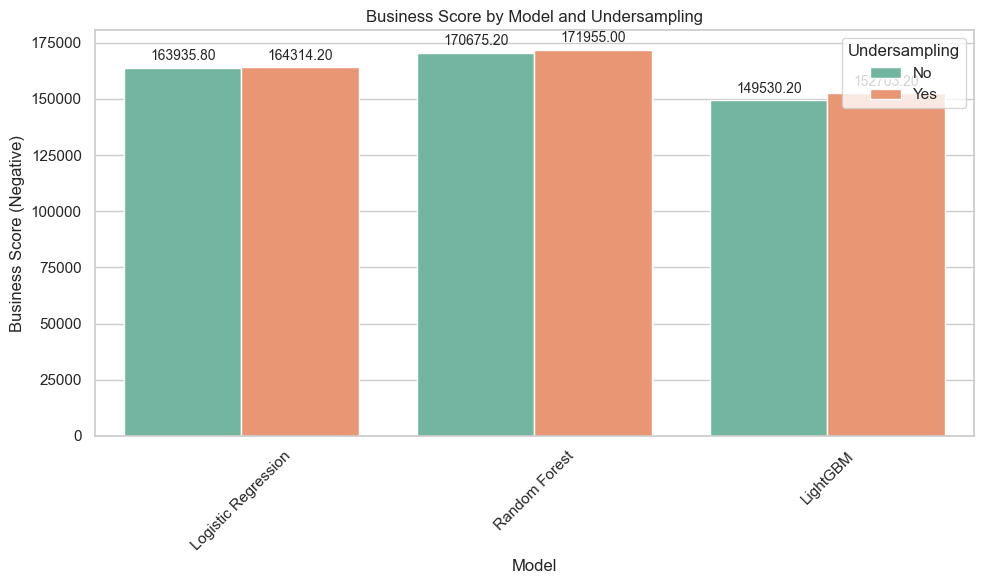

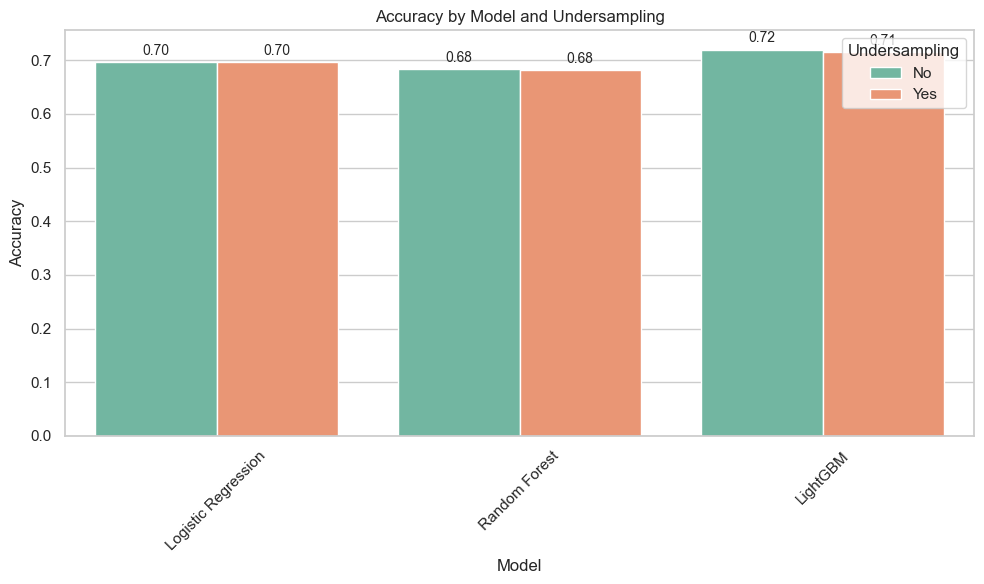

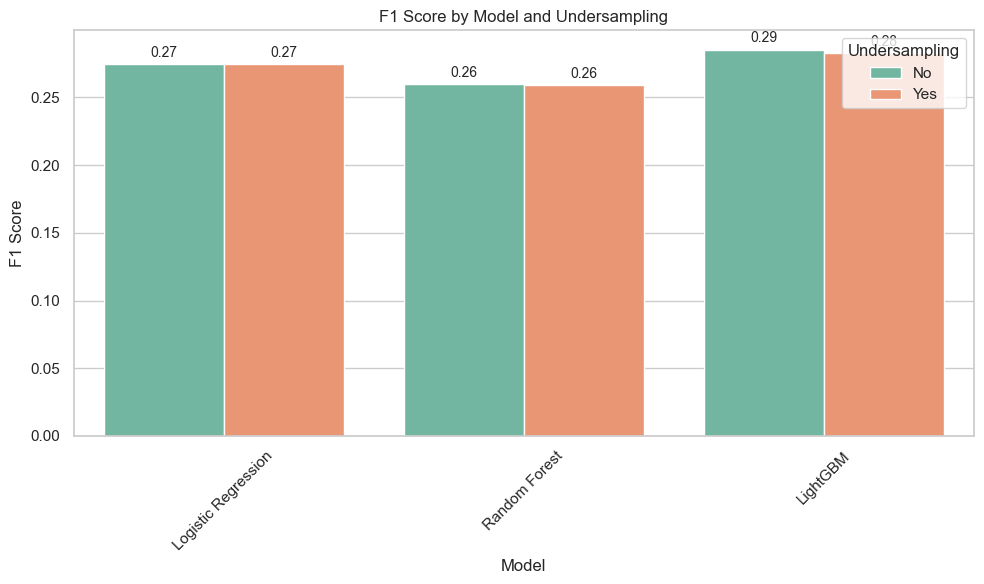

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration g√©n√©rale de Seaborn
sns.set(style="whitegrid")

# Liste des m√©triques √† visualiser
metrics = ["Business Score", "Accuracy", "F1 Score"]

# Cr√©ation des barplots pour chaque m√©trique
for metric in metrics:
    plt.figure(figsize=(10, 6))
    
    # Si la m√©trique est "Business Score", multiplier par -1
    if metric == "Business Score":
        plot_data = combined_results_df.copy()
        plot_data[metric] *= -1
    else:
        plot_data = combined_results_df

    ax = sns.barplot(
        data=plot_data,
        x="Model",
        y=metric,
        hue="Undersampling",
        palette="Set2"
    )
    
    # Ajouter les valeurs sur chaque barre
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10, padding=3)

    plt.title(f"{metric} by Model and Undersampling")
    plt.xlabel("Model")
    plt.ylabel(metric if metric != "Business Score" else f"{metric} (Negative)")
    plt.legend(title="Undersampling")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### LignhtGBM sans undersampling - meilleur modele

### R√©cup√©rer le mod√®le LightGBM sans undersampling.
Appliquer la fonction predict_proba pour obtenir les probabilit√©s des classes.
Varier le seuil de 0.2 √† 0.8 avec un pas de 0.05.
Calculer le score m√©tier pour chaque seuil.
Choisir le seuil avec le meilleur score m√©tier.

In [117]:
X.shape

(291377, 551)

In [118]:
X.columns

Index(['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=551)

In [119]:
X.head()

SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0      100002            0             0                0             0   
1      100003            1             0                1             0   
2      100004            0             1                0             0   
3      100006            1             0                0             0   
4      100007            0             0                0             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          202500.0    406597.5      24700.5         351000.0   
1          270000.0   1293502.5      35698.5        1129500.0   
2           67500.0    135000.0       6750.0         135000.0   
3          135000.0    312682.5      29686.5         297000.0   
4          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  ...  INSTAL_AMT_INSTALMENT_MEAN  \
0                    0.018801  ...                11559.247070   
1                    0.003541  ...                64754.585938   
2                    0.010032  ...                 7096.154785   
3                    0.008019  ...                62947.089844   
4                    0.028663  ...                12666.444336   

   INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  INSTAL_AMT_PAYMENT_MAX  \
0               2.196257e+05             9251.775391            53093.746094   
1               1.618865e+06             6662.970215           560835.375000   
2               2.128846e+04             5357.250000            10573.964844   
3               1.007153e+06             2482.919922           691786.875000   
4               8.359853e+05                0.180000            22678.785156   

   INSTAL_AMT_PAYMENT_MEAN  INSTAL_AMT_PAYMENT_SUM  \
0             11559.247070            2.196257e+05   
1             64754.585938            1.618865e+06   
2              7096.154785            2.128846e+04   
3             62947.089844            1.007153e+06   
4             12214.060547            8.061280e+05   

   INSTAL_DAYS_ENTRY_PAYMENT_MAX  INSTAL_DAYS_ENTRY_PAYMENT_MEAN  \
0                          -49.0                     -315.421051   
1                         -544.0                    -1385.319946   
2                         -727.0                     -761.666687   
3                          -12.0                     -271.625000   
4                          -14.0                    -1032.242432   

   INSTAL_DAYS_ENTRY_PAYMENT_SUM  INSTAL_COUNT  
0                        -5993.0          19.0  
1                       -34633.0          25.0  
2                        -2285.0           3.0  
3                        -4346.0          16.0  
4                       -68128.0          66.0  

[5 rows x 551 columns]

In [120]:
y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: TARGET, dtype: float64

In [121]:
X_train.head()

SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
151531      275645            0             0                0             0   
160424      285969            1             0                0             0   
203849      336331            1             0                0             0   
300030      447581            1             1                1             0   
218527      353171            0             0                0             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
151531          180000.0    275040.0      13504.5         180000.0   
160424           67500.0    305640.0      31446.0         270000.0   
203849          180000.0    270000.0      13500.0         270000.0   
300030          135000.0    936018.0      30325.5         670500.0   
218527          135000.0    343287.0      27121.5         310500.0   

        REGION_POPULATION_RELATIVE  ...  INSTAL_AMT_INSTALMENT_MEAN  \
151531                    0.008575  ...                10420.304362   
160424                    0.035792  ...                17707.980000   
203849                    0.004960  ...                21958.200000   
300030                    0.019689  ...                49064.877422   
218527                    0.025164  ...                16281.171667   

        INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  \
151531                 489754.305                 223.065   
160424                 159371.820               15987.915   
203849                 109791.000               21958.200   
300030                3140152.155                4898.835   
218527                 439591.635                 928.395   

        INSTAL_AMT_PAYMENT_MAX  INSTAL_AMT_PAYMENT_MEAN  \
151531               21709.125              8999.263723   
160424               31468.500             17707.980000   
203849               21958.200             21958.200000   
300030              239641.515             48638.972109   
218527               67500.000             16281.171667   

        INSTAL_AMT_PAYMENT_SUM  INSTAL_DAYS_ENTRY_PAYMENT_MAX  \
151531              422965.395                          -57.0   
160424              159371.820                        -2353.0   
203849              109791.000                          -26.0   
300030             3112894.215                          -28.0   
218527              439591.635                          -23.0   

        INSTAL_DAYS_ENTRY_PAYMENT_MEAN  INSTAL_DAYS_ENTRY_PAYMENT_SUM  \
151531                     -821.063830                       -38590.0   
160424                    -2498.888889                       -22490.0   
203849                      -88.600000                         -443.0   
300030                    -1027.796875                       -65779.0   
218527                     -170.333333                        -4599.0   

        INSTAL_COUNT  
151531          47.0  
160424           9.0  
203849           5.0  
300030          64.0  
218527          27.0  

[5 rows x 551 columns]

In [122]:
y_train.head()

151531    0.0
160424    0.0
203849    0.0
300030    1.0
218527    0.0
Name: TARGET, dtype: float64

In [123]:
y.shape

(291377,)

### Seuil de classification pour meilleur mod√®le

In [124]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Fonction pour ajuster le seuil de classification
def tune_classification_threshold_lightgbm(model, X, y, scoring_function, thresholds=np.arange(0.2, 0.85, 0.05)):
    results = []
    y_proba = model.predict_proba(X)[:, 1]  # Probabilit√©s de la classe positive

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)  # Conversion en classes binaires
        print(y_proba, y_pred, threshold)
        print(scoring_function(y,y_pred))
        business_score = scoring_function(y, y_pred)  # Calcul du score m√©tier 
        results.append({
            "Threshold": threshold,
            "Business Score": business_score
        })

    return pd.DataFrame(results)


# Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Renommer les colonnes pour √©viter les conflits
X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in X_train.columns])
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Entra√Ænement du mod√®le LightGBM
model = lgb.LGBMClassifier(random_state=42, num_leaves=31, learning_rate=0.1, n_estimators=100, max_depth=10)
# model.fit(X_train, y_train)
model.fit(np.array(X_train), np.array(y_train))

# Ajustement des seuils
threshold_results = tune_classification_threshold_lightgbm(
    model=model,
    X=X_test,
    y=y_test,
    scoring_function=business_score_metric
)

# Trouver le meilleur seuil
best_threshold = threshold_results.loc[threshold_results['Business Score'].idxmin()]
print(f"Meilleur seuil : {best_threshold['Threshold']} avec un Business Score de : {best_threshold['Business Score']}")


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 19048, number of negative: 214053
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 233101, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081716 -> initscore=-2.419262
[LightGBM] [Info] Start training from score -2.419262
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trainin

In [125]:
threshold_results

Threshold  Business Score
0        0.20            4826
1        0.25            4826
2        0.30            4826
3        0.35            4826
4        0.40            4826
5        0.45            4826
6        0.50            4826
7        0.55            4826
8        0.60            4826
9        0.65            4826
10       0.70            4826
11       0.75            4826
12       0.80            4826

In [128]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def tune_classification_threshold_lightgbm_cv(model, X, y, scoring_function, 
                                               thresholds=np.arange(0.2, 0.85, 0.05),
                                               cv=5):
    """
    Function to find the best classification threshold using cross-validation.

    Parameters:
    - model: The trained LightGBM model.
    - X: Features (DataFrame or ndarray).
    - y: Target variable (array-like).
    - scoring_function: Function to calculate the business score.
    - thresholds: Array of thresholds to evaluate.
    - cv: Number of cross-validation folds.

    Returns:
    - DataFrame containing thresholds and their corresponding mean business scores.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    results = []

    for threshold in thresholds:
        fold_scores = []
        for train_idx, val_idx in skf.split(X, y):
            #X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            #y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]


            # Train the model on the fold
            model.fit(X_train_fold, y_train_fold)
            
            # Predict probabilities on the validation fold
            y_proba = model.predict_proba(X_val_fold)[:, 1]
            
            # Convert probabilities to binary predictions based on the threshold
            y_pred = (y_proba >= threshold).astype(int)
            
            # Calculate the business score for this fold
            fold_score = scoring_function(y_val_fold, y_pred)
            fold_scores.append(fold_score)

        # Calculate the mean score across folds for this threshold
        mean_score = np.mean(fold_scores)
        results.append({
            "Threshold": threshold,
            "Mean Business Score": mean_score
        })

    return pd.DataFrame(results)

# Example usage:
# Define a dummy scoring function for illustration
def business_score_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp - fp  # Example business score: true positives minus false positives

# Assume X and y are already defined
# X = np.random.rand(1000, 10)  # Replace with actual data
# y = np.random.randint(0, 2, size=1000)  # Replace with actual labels

# Instantiate the LightGBM model
model = lgb.LGBMClassifier(random_state=42, num_leaves=31, learning_rate=0.1, 
                           n_estimators=100, max_depth=10)

# Nettoyer les noms de colonnes de X
if isinstance(X, pd.DataFrame):
    import re
    X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]

# V√©rifiez que cela fonctionne
print(X.columns)  # Les noms de colonnes devraient maintenant √™tre sans caract√®res sp√©ciaux


# Find the best threshold using cross-validation
threshold_results_cv = tune_classification_threshold_lightgbm_cv(
    model=model,
    X=X,
    y=y,
    scoring_function=business_score_metric
)

# Find the threshold with the highest mean business score
best_threshold_cv = threshold_results_cv.loc[threshold_results_cv['Mean Business Score'].idxmax()]
print(f"Best threshold: {best_threshold_cv['Threshold']} with a mean business score of: {best_threshold_cv['Mean Business Score']}")

Index(['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=551)
[LightGBM] [Info] Number of positive: 19099, number of negative: 214002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.098742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55848
[LightGBM] [Info] Number of data points in the train set: 233101, number of used features: 509
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081934 -> initscore=-2.416